In [7]:
import os,sys

from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
import shutil
import numpy as np

# //////////////////////////////////////////////////////
def LoadImage(filename):
	if filename.startswith('http'):
		filename=urlopen(filename) 
	return  np.asarray(Image.open(filename))

# //////////////////////////////////////////////////////
def ShowImage(data):
	data=np.flip(data,axis=0)
	print("shape",data.shape,"dtype",str(data.dtype))
	fig = plt.figure()
	ax = fig.add_subplot(1,1,1)
	ax.imshow(data, origin='lower')
	plt.show()

sys.path.append("C:/projects/OpenVisus/build/RelWithDebInfo")
import OpenVisus as ov

# Load an image

shape (2048, 2048) dtype float32


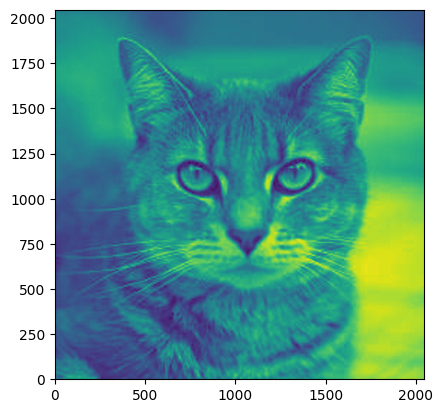

In [8]:
data=LoadImage('https://raw.githubusercontent.com/sci-visus/OpenVisus/master/datasets/cat/gray.png')

# make the example as similar as possible to what we need
data=data.astype(np.float32)

# I want the image bigger (to produce more blocks)
import cv2
data=cv2.resize(data, dsize=(2048, 2048), interpolation=cv2.INTER_CUBIC)

ShowImage(data)

# Create IDX

In [9]:
%%time

import struct,io,time
from io import BytesIO

# since I am writing/reading in multiple threads, I will not have collisions and I will not need file locks
os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"

# /////////////////////////////////////////////////////////////
def CreateRamAccess(db):
    ret=db.createAccess(ov.StringTree.fromString("<access type='RamAccess' chmod='rw' available='0' compression='raw'/>"))
    ret.disableWriteLocks()
    assert(ret.bDisableWriteLocks==True)
    assert(ret.compression=="")
    assert(str(ret.getAccessTypeName())=="class Visus::RamAccess")
    return ret

dims=list(reversed(data.shape))
dtype=str(data.dtype)

# using a temporary filename , so I am sure I can remove the directory
idx_filename='visus-remove-me/visus.idx'
assert('visus-remove-me' in idx_filename)
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)

db=ov.CreateIdx(
    url=idx_filename, 
    dims=dims, 
    fields=[
        ov.Field('temperature',dtype,'row_major'),  # example with 2 fields jut to make it more complicate
        ov.Field('pressure',   dtype,'row_major')
    ],
    # writing at the beginning should be uncompressed 
    compression="raw"
    )

# make sure the file has been created
assert(os.path.isfile(idx_filename))

blocksperfile=db.idxfile.blocksperfile
total_blocks=db.getTotalNumberOfBlocks()
fields=db.getFields()
nfields=len(fields)
pdim=db.getPointDim()
num_files=total_blocks//blocksperfile
file_header_size=10*4
block_header_size=10*4
header0=np.zeros(shape=[file_header_size+nfields*blocksperfile*block_header_size,],dtype=np.uint8)
assert(num_files*blocksperfile==total_blocks)

print(f"header0       ={header0.nbytes}")
print(f"total_blocks  ={total_blocks}")
print(f"fields        ={fields}")
print(f"pdim          ={pdim}")
print(f"num_files     ={num_files}")
print(f"blocksperfile ={blocksperfile}")
print(f"header0       ={header0.nbytes}")
print("")

print(db.getDatasetBody().toString())

# db.write(data,field=db.getField("temperature"))
# db.write(data,field=db.getField("pressure"))

header0       =5160
total_blocks  =64
fields        =['temperature', 'pressure']
pdim          =2
num_files     =1
blocksperfile =64
header0       =5160

<dataset url="visus-remove-me/visus.idx" cache_dir="" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V0101010101010101010101" />
		<box value="0 2048 0 2048" />
		<bitsperblock value="16" />
		<blocksperfile value="64" />
		<block_interleaving value="0" />
		<filename_template value="./visus/%04x.bin" />
		<missing_blocks value="False" />
		<arco value="0" />
		<time_template value="" />
		<axis value="" />
		<field name="temperature" description="" index="" default_compression="" default_layout="" default_value="0" filter="" dtype="float32" />
		<field name="pressure" description="" index="" default_compression="" default_layout="" default_value="0" filter="" dtype="float32" />
		<timestep when="0" />
	</idxfile>
</dataset>
CPU times: total: 0 ns
Wall time: 10.5 ms


# Write data in memory
 - uncompressed
 - not using any disk IO

Writing timestep=0 field=temperature...done
Writing timestep=0 field=pressure...done
shape (2048, 2048) dtype float32


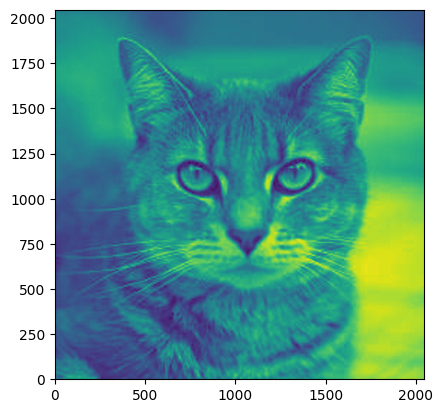

shape (2048, 2048) dtype float32


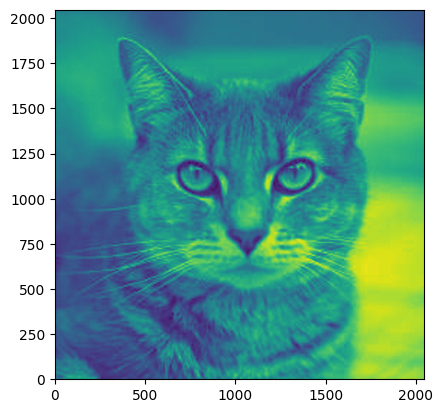

CPU times: total: 734 ms
Wall time: 1.07 s


In [10]:
%%time

# by specifying an `access` I tell OpenVisus to write in memory and not on disk
ram_access=CreateRamAccess(db)

# for each timestep
for timestep in db.getTimesteps():
  
  # for each field
  for field in db.getFields():

    # here I am writing the HDF5 (or numpy data, or whatever)
    # this is called BoxQuery (equivalent to writing a Region of Interest)
    print(f"Writing timestep={timestep} field={field}...",end="")
    logic_box=db.getLogicBox()
    query = db.createBoxQuery(ov.BoxNi(ov.PointNi(logic_box[0]),ov.PointNi(logic_box[1])), db.getField(field), timestep, ord('w'))
    db.beginBoxQuery(query)
    assert(query.isRunning())
    query.buffer = ov.Array.fromNumPy(data,TargetDim=pdim, bShareMem=True)
    assert(db.executeBoxQuery(ram_access, query))
    print("done")

# Here I am reding blocks (all in memory) and converting them into numpy arrays
# using a dict to make block looking simplier
blocks={}
for timestep in db.getTimesteps():
  for field in db.getFields():
    for blockid in range(total_blocks):
      read_block = db.createBlockQuery(blockid, db.getField(field), timestep, ord('r'))
      if db.executeBlockQueryAndWait(ram_access, read_block): 
        # scrgiorgio: if I share the memory here I have a problem... why????
        blocks[(timestep, field, blockid)]=ov.Array.toNumPy(read_block.buffer, bShareMem=False) 

# remove in production
verify=True
if verify:
  for field in fields:
    check=db.read(time=timestep,field=db.getField(field), access=ram_access)
    assert(np.array_equal(data, check))
    ShowImage(check)

# Write blocks to disk using Python

Writing filename=c:/projects/openvisuspy/notebooks/visus-remove-me/visus/0000.bin...
Writing filename=c:/projects/openvisuspy/notebooks/visus-remove-me/visus/0000.bin DONE
shape (2048, 2048) dtype float32


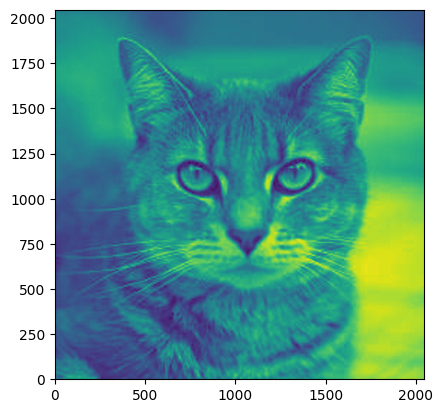

shape (2048, 2048) dtype float32


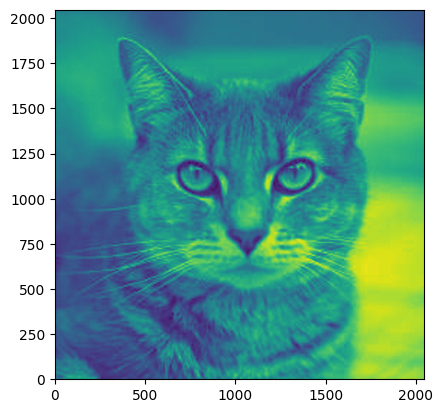

CPU times: total: 1.61 s
Wall time: 3.11 s


In [11]:
%%time

import zlib

NoCompression   = 0x00
ZipMask         = 0x03
ZfpCompression  = 0x08
CompressionMask = 0x0f

RowMajor        = 0x10

# use empty string or `zip` here
compression="zip"

# TODO (!)
assert(compression!="zfp") 

# at the beginning I am using a disk access to generate filename, later on to verify the data
disk_access=db.createAccess()

# write binary data using python
for timestep in db.getTimesteps():
	for fileid, BLOCKID in enumerate(range(0,total_blocks,blocksperfile)):

		# create the file
		filename=disk_access.getFilename(db.getField(), timestep, BLOCKID)
		print(f"Writing filename={filename}...")
		os.makedirs(os.path.dirname(filename),exist_ok =True)
		
		# compose the file in memory (is it faster than seeking a normal file?)
		stream=BytesIO()
		stream.write(header0.tobytes())
		for field_index,field in enumerate(fields):
			for B,blockid in enumerate(range(BLOCKID,BLOCKID+blocksperfile)):
				block=blocks.get((timestep,field,blockid),None)
				if block is None:  continue

				flags=RowMajor

				# no need to compress
				if compression in ["","raw"]:
					block=block.tobytes()
					flags|=0

				# need to compress in zip
				elif compression=="zip":
					block=zlib.compress(block,level=-1)
					flags|=ZipMask

				# write the binary data
				stream.seek(0, io.SEEK_END)
				offset=stream.tell()
				size=len(block)
				stream.write(block)

				# write the file header
				stream.seek(file_header_size+block_header_size*(field_index*blocksperfile+B), io.SEEK_SET)
				stream.write(struct.pack('>IIIIIIIIII', 0,0, offset & 0xffffffff, offset>>32, size, flags,0,0,0,0))

				# print(f"Wrote block timestep={timestep} field={field} field_index={field_index} blockid={blockid} B={B} offset={offset} size={size} flags={flags}")

		# finally write all the data to disk
		with open(filename, "wb") as f:
			f.write(stream.getbuffer())	
		print(f"Writing filename={filename} DONE")

# remove in production
verify=True
if verify:
	for field in fields:
		check=db.read(field=field,access=disk_access)
		assert(np.array_equal(data, check))
		ShowImage(check)